In [1]:
import infrastructure as infra
import pandas as pd
import geopandas as gpd
import glob
import warnings
import numpy as np

The goal of this notebook is to explore and compare inactive assets in the Dutch North Sea.

There are several approaches:
1. Use the production data: which wellbores stopped producing and what infrastructure is connected?
2. Use platform, pipeline and wellbore data and look for inactive assets. 
3. Do both (preferred)

The result should be a csv with inactive properties we can use to compare with the official records from the Dutch agencies.

### Import well production stats

In [2]:
PATH = '../../energy/fossil_fuels/data/production/nl_production/'

In [3]:
def parse_commodity(commodity):
    dfs = []
    for file in glob.glob(f'{PATH}per_well/well{commodity}Produced_*.xlsx'):
        df = pd.read_excel(file, skiprows=1, skipfooter=1)
        df = df.melt(['FIELD', 'WELL', 'OPERATOR', 'YEAR'], var_name='MONTH', value_name='sm3')
        df['date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'] + '-01')
        if commodity == 'Oil':
            df['sm3'] = df['sm3'] * 1000
        df['COMMODITY'] = commodity
        df.YEAR = df.YEAR.astype('int')
        df = df.rename(columns={'WELL': 'well_name',
                                'FIELD': 'field_name',
                                'OPERATOR': 'operator_name',
                                'YEAR': 'production_year',
                                'MONTH': 'month',
                                'COMMODITY': 'commodity'})

        dfs.append(df)

    df = pd.concat(dfs)
    return df

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    df = parse_commodity('Gas')

In [4]:
# Replace nan values in sm3: I assume that no value equals 0 output

df.sm3 = df.sm3.fillna(0)

In [5]:
# Select all inactive wells and months and only gas for now

inactive = df[(df.sm3 < 1) & (df.date < '2023-02-01') & (df.commodity=='Gas')].copy()
len(inactive)

34784

In [6]:
# Groupby wells and select wells with highest number of inactive months

df1 = inactive.groupby(['well_name', 'field_name', 'operator_name']).agg(min_date_inactive=('date', 'min'),
                                                                   max_date_inactive=('date', 'max'),
                                                                   number_of_months_inactive=('date', 'count')).reset_index()
df1.head()

,well_name,field_name,operator_name,min_date_inactive,max_date_inactive,number_of_months_inactive
0,49/05A-B-01,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,124
1,49/05A-B-02,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,127
2,49/05A-B-03,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,144
3,49/05A-B-04,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,115
4,49/05A-B-05,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,108


In [7]:
# Group original data

df2 = df.groupby('well_name').agg(min_date=('date', 'min'),
                                max_date=('date', 'max')).reset_index()

df2.head()

,well_name,min_date,max_date
0,49/05A-B-01,2011-01-01,2022-12-01
1,49/05A-B-02,2011-01-01,2022-12-01
2,49/05A-B-03,2011-01-01,2022-12-01
3,49/05A-B-04,2011-01-01,2022-12-01
4,49/05A-B-05,2011-01-01,2022-12-01


In [8]:
# And bring inactive wells together

wells = pd.merge(df1, df2, on='well_name', how='left')

wells['total_months'] = ((wells.max_date - wells.min_date)/np.timedelta64(1, 'M')).astype('int')
wells['perc_inactive'] = wells.number_of_months_inactive / wells.total_months

wells.head()

,well_name,field_name,operator_name,min_date_inactive,max_date_inactive,number_of_months_inactive,min_date,max_date,total_months,perc_inactive
0,49/05A-B-01,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,124,2011-01-01,2022-12-01,142,0.873239
1,49/05A-B-02,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,127,2011-01-01,2022-12-01,142,0.894366
2,49/05A-B-03,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,144,2011-01-01,2022-12-01,142,1.014085
3,49/05A-B-04,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,115,2011-01-01,2022-12-01,142,0.809859
4,49/05A-B-05,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,108,2011-01-01,2022-12-01,142,0.760563


The next step is to compare wells with large amount of non productivity and the official status of wellbores. If there is a discrepancy - for instance a wellbore is listed as suspended but has a large number of non-active months, that could be a lead. 

In [9]:
# Import wellbores

wellbores = infra.get_wellbores(['nl'], eez=True)
len(wellbores)

Imported 2381 rows from nl: nl_wellbores


2286

In [10]:
# Merge with wellbore data to compare status with production observations

w = pd.merge(wells, wellbores, left_on='well_name', right_on='infra_name', how='left')
w.head()

,well_name,field_name,operator_name,min_date_inactive,max_date_inactive,number_of_months_inactive,min_date,max_date,total_months,perc_inactive,...,infra_type,status,geometry,country,status_normalised,type_normalised,name_db,name_local,name_normalised,country_operator
0,49/05A-B-01,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,124,2011-01-01,2022-12-01,142,0.873239,...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49/05A-B-02,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,127,2011-01-01,2022-12-01,142,0.894366,...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49/05A-B-03,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,144,2011-01-01,2022-12-01,142,1.014085,...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49/05A-B-04,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,115,2011-01-01,2022-12-01,142,0.809859,...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49/05A-B-05,Markham,Spirit Energy Nederland B.V.,2011-01-01,2022-12-01,108,2011-01-01,2022-12-01,142,0.760563,...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Succesful merges

print(f'{len(w[w.infra_name.notna()])} were succesfully merged and {len(w[w.infra_name.isna()])} not')

530 were succesfully merged and 62 not


In [12]:
# Check status for the above .75 percent idle wells

w[w.perc_inactive >= 0.75].status.value_counts()

Abandoned                       35
Plugged back and sidetracked    18
Suspended                       14
Closed-in                       13
Producing/Injecting              6
Plugged                          1
Name: status, dtype: int64

In [13]:
def plot_wells(df, wells):
    return df[df.well_name.isin(wells)]\
    .set_index('date')\
    .groupby('well_name', group_keys=False)['sm3']\
    .plot(legend=True)

In [14]:
selection = w[(w.perc_inactive >= 0.5) & (w.status=='Producing/Injecting')]

well_name
D12-A-04         Axes(0.125,0.11;0.775x0.77)
J06-A-02         Axes(0.125,0.11;0.775x0.77)
K04-BE-02        Axes(0.125,0.11;0.775x0.77)
K05-D-03         Axes(0.125,0.11;0.775x0.77)
K05-D-04         Axes(0.125,0.11;0.775x0.77)
K05-ENC-01       Axes(0.125,0.11;0.775x0.77)
K08-FA-102       Axes(0.125,0.11;0.775x0.77)
K09C-A-02        Axes(0.125,0.11;0.775x0.77)
K09C-A-06        Axes(0.125,0.11;0.775x0.77)
K14-FA-103       Axes(0.125,0.11;0.775x0.77)
K15-FA-108       Axes(0.125,0.11;0.775x0.77)
K15-FC-104       Axes(0.125,0.11;0.775x0.77)
L02-FA-105       Axes(0.125,0.11;0.775x0.77)
L10-A-05         Axes(0.125,0.11;0.775x0.77)
L10-E-01         Axes(0.125,0.11;0.775x0.77)
L10-F-04         Axes(0.125,0.11;0.775x0.77)
P15-RIJN-A-03    Axes(0.125,0.11;0.775x0.77)
P15-RIJN-A-05    Axes(0.125,0.11;0.775x0.77)
P15-RIJN-A-10    Axes(0.125,0.11;0.775x0.77)
Q13-A-02         Axes(0.125,0.11;0.775x0.77)
Name: sm3, dtype: object

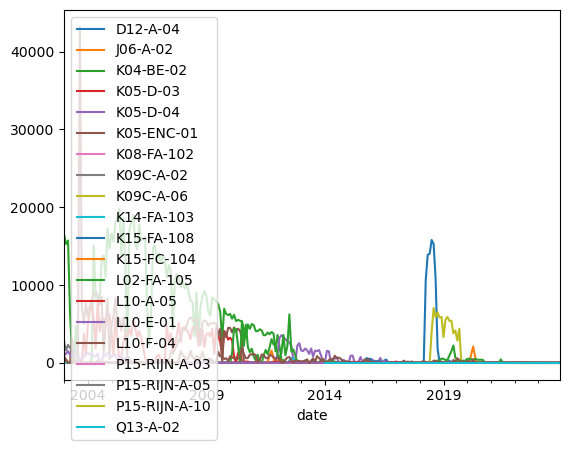

In [15]:
plot_wells(df, selection.well_name.tolist())

In [16]:
gpd.GeoDataFrame(selection[['well_name', 'status', 'geometry']]).explore()

In [35]:
wellbores[wellbores.infra_name.str.contains('K05')].status.value_counts()

Producing/Injecting             19
Plugged back and sidetracked    17
Abandoned                        6
Closed-in                        5
Suspended                        3
Name: status, dtype: int64

In [18]:
len(df)

109020

In [19]:
prodwell = pd.merge(df, 
                    wellbores, 
                    left_on='well_name', 
                    right_on='infra_name', 
                    how='left')
len(prodwell)

109020

In [20]:
print(f'{len(prodwell[prodwell.infra_type.isna()])} rows could not be matched\n\
and these are {prodwell[prodwell.infra_type.isna()].well_name.nunique()} unique wells')

10356 rows could not be matched
and these are 63 unique wells


This means that 63 wells are mentioned in the production database, but not in the wellbore database, or they are listed under another name.

In [21]:
# Let's get some examples from those non-matches

prodwell[prodwell.infra_type.isna()].well_name.value_counts()

K04-A-03       252
P18-6A7        252
P15-11F2       252
P15-11F1       252
P18-2A3        252
              ... 
L1/7            36
MAASMOND-01     36
L9/4            24
L8/10           24
L7/2            24
Name: well_name, Length: 63, dtype: int64

well_name
K04-A-03    Axes(0.125,0.11;0.775x0.77)
Name: sm3, dtype: object

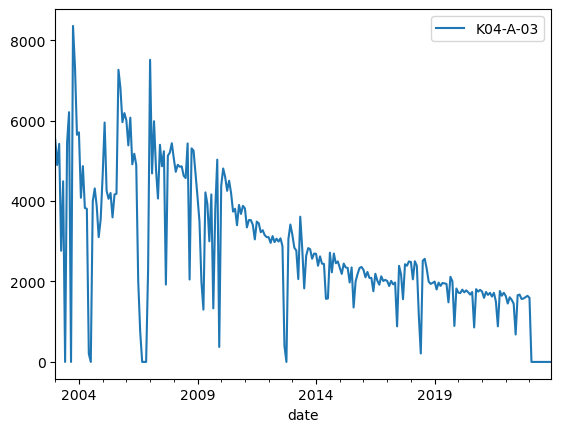

In [22]:
# This well is producing

plot_wells(prodwell, ['K04-A-03'])

In [23]:
# But it's not in the official database, or under another name

wellbores[wellbores.infra_name.str.contains('K04-A-')]

,feature_id,infra_name,operator,start_date,end_date,infra_type,status,geometry,country,status_normalised,type_normalised,name_db,name_local,name_normalised,country_operator
1569,4438,K04-A-01,TOTAL,1990-09-18,1991-01-28,Exploratie koolwaterstof,Plugged back and sidetracked,POINT (520508.000 5955991.000),nl,In use,Exploration well,TOTAL,TOTALENERGIES,TOTALENERGIES,France
1570,4439,K04-A-01-S1,ELF PETROLAND,1998-07-19,1998-12-07,Ontwikkeling koolwaterstof,Producing/Injecting,POINT (520508.000 5955991.000),nl,In use,Development well,ELF PETROLAND,TOTALENERGIES,TOTALENERGIES,France
1596,4788,K04-A-04,ELF PETROLAND,2000-08-05,2000-10-23,Ontwikkeling koolwaterstof,Plugged back and sidetracked,POINT (520509.000 5955993.000),nl,In use,Development well,ELF PETROLAND,TOTALENERGIES,TOTALENERGIES,France
1597,4790,K04-A-04-S2,ELF PETROLAND,2000-11-13,2000-12-04,Ontwikkeling koolwaterstof,Producing/Injecting,POINT (520509.000 5955993.000),nl,In use,Development well,ELF PETROLAND,TOTALENERGIES,TOTALENERGIES,France
1598,4789,K04-A-04-S1,ELF PETROLAND,2000-10-27,2000-11-13,Ontwikkeling koolwaterstof,Abandoned,POINT (520509.000 5955993.000),nl,Not in use,Development well,ELF PETROLAND,TOTALENERGIES,TOTALENERGIES,France
1600,5903,K04-A-06,TOTAL,2009-12-12,2010-03-22,Ontwikkeling koolwaterstof,Producing/Injecting,POINT (520510.000 5955994.000),nl,In use,Development well,TOTAL,TOTALENERGIES,TOTALENERGIES,France
1602,5773,K04-A-02,ELF PETROLAND,1995-10-19,1995-12-04,Exploratie koolwaterstof,Plugged back and sidetracked,POINT (520507.000 5955994.000),nl,In use,Exploration well,ELF PETROLAND,TOTALENERGIES,TOTALENERGIES,France
1604,5271,K04-A-05-S2,TOTAL,2006-08-22,2006-11-03,Ontwikkeling koolwaterstof,Producing/Injecting,POINT (520511.000 5955996.000),nl,In use,Development well,TOTAL,TOTALENERGIES,TOTALENERGIES,France
1605,5266,K04-A-05,TOTAL,2006-07-21,2006-08-16,Ontwikkeling koolwaterstof,Plugged back and sidetracked,POINT (520511.000 5955996.000),nl,In use,Development well,TOTAL,TOTALENERGIES,TOTALENERGIES,France
1606,5269,K04-A-05-S1,TOTAL,2006-08-16,2006-08-22,Ontwikkeling koolwaterstof,Abandoned,POINT (520511.000 5955996.000),nl,Not in use,Development well,TOTAL,TOTALENERGIES,TOTALENERGIES,France


## Platforms

In [36]:
platforms = infra.get_platforms(['nl'], eez=True, only_platforms=False)
len(platforms)

Imported 252 rows from nl: nl_facility


252

In [44]:
platforms[platforms.infra_name.str.contains('K0')]

,feature_id,infra_name,status,infra_type,operator,geometry,description,country,status_normalised,type_normalised,name_db,name_local,name_normalised,country_operator
126,118117747.0,K08-FA-2,In gebruik,Productieplatform,NAM,POINT (527690.747 5929591.757),K8-FA-2,nl,In use,Platform,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
133,118117717.0,K09ab-A,In gebruik,Productieplatform,NEPTUNE,POINT (565796.536 5930581.786),K9ab-A,nl,In use,Platform,NEPTUNE,NEPTUNE ENERGY GROUP LIMITED,NEPTUNE ENERGY GROUP LIMITED,United Kingdom
134,118117646.0,K09ab-A (Total),In gebruik,Productieplatform,TOTAL,POINT (565796.536 5930581.786),K9abA,nl,In use,Platform,TOTAL,TOTALENERGIES,TOTALENERGIES,France
136,118117718.0,K09ab-B,In gebruik,Productieplatform,NEPTUNE,POINT (551653.612 5933855.755),K9ab-B,nl,In use,Platform,NEPTUNE,NEPTUNE ENERGY GROUP LIMITED,NEPTUNE ENERGY GROUP LIMITED,United Kingdom
137,118117748.0,K08-FA-3,In gebruik,Productieplatform,NAM,POINT (527977.743 5932583.741),K8-FA-3,nl,In use,Platform,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
138,250309162.0,K08-FA-3A,In gebruik,Productieplatform,NAM,POINT (527977.743 5932583.741),K8-FA-3A,nl,In use,Platform,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
139,118117745.0,K07-FD-1,In gebruik,Productieplatform,NAM,POINT (517706.140 5933520.696),K7-FD-1,nl,In use,Platform,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
142,118117744.0,K07-FB-1,In gebruik,Productieplatform,NAM,POINT (504566.778 5942362.356),K7-FB-1,nl,In use,Platform,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
150,118117719.0,K09c-A,In gebruik,Productieplatform,NEPTUNE,POINT (557688.568 5945215.698),K9c-A,nl,In use,Platform,NEPTUNE,NEPTUNE ENERGY GROUP LIMITED,NEPTUNE ENERGY GROUP LIMITED,United Kingdom
151,118117642.0,K06-D,In gebruik,Productieplatform,TOTAL,POINT (554712.582 5947677.682),K6-D,nl,In use,Platform,TOTAL,TOTALENERGIES,TOTALENERGIES,France


In [37]:
platforms[platforms.status_normalised.isin(['Not in use', 'Removed'])].to_csv('../data/inactive/platforms.csv')

In [38]:
platforms.status_normalised.value_counts()

In use        194
Removed        47
Not in use     11
Name: status_normalised, dtype: int64

## Pipelines

In [39]:
pipes = infra.get_pipelines(['nl'], eez=True)
len(pipes)

Imported 492 rows from nl: nl_pipelines


359

In [40]:
pipes[pipes.status_normalised=='Not in use'].to_csv('../data/inactive/pipes.csv')

## Wellbores

In [41]:
wellbores.status_normalised.value_counts()

Not in use    1592
In use         638
Name: status_normalised, dtype: int64

In [30]:
wellbores[wellbores.status_normalised=='In use'].to_csv('../data/inactive/wellbores.csv')

In [31]:
w = list(inactive.well_name)

In [32]:
wellbores[(~wellbores.infra_name.isin(w)) & (wellbores.status!='Abandoned')]

,feature_id,infra_name,operator,start_date,end_date,infra_type,status,geometry,country,status_normalised,type_normalised,name_db,name_local,name_normalised,country_operator
25,2787,SPKO-01,NAM,1990-05-08,1990-05-25,Exploratie koolwaterstof,Plugged back and sidetracked,POINT (593934.000 5744588.000),nl,In use,Exploration well,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
26,6145,SPKO-01-S2,NAM,2012-11-01,2012-11-17,Ontwikkeling koolwaterstof,Producing/Injecting,POINT (593934.000 5744588.000),nl,In use,Development well,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
27,2850,SPKO-02,NAM,1992-12-12,1993-01-21,Exploratie koolwaterstof,Plugged back and sidetracked,POINT (593935.000 5744618.000),nl,In use,Exploration well,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
28,2851,SPKO-02-S1,NAM,1993-01-21,1993-02-02,Exploratie koolwaterstof,Producing/Injecting,POINT (593935.000 5744618.000),nl,In use,Exploration well,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
29,6532,SPKO-04,NAM,2020-03-13,2020-04-13,Exploratie koolwaterstof,None,POINT (593942.000 5744637.000),nl,None,Exploration well,NAM,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,NEDERLANDSE AARDOLIE MAATSCHAPPIJ B.V.,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,6046,B13-A-03,CHEVRON,2011-07-16,2011-09-14,Ontwikkeling koolwaterstof,Producing/Injecting,POINT (569751.000 6127245.000),nl,In use,Development well,CHEVRON,CHEVRON CORPORATION,CHEVRON CORPORATION,United States
2350,6343,A18-A-03,PETROGAS E&P NETHERLANDS B.V.,2015-11-13,2016-01-16,Ontwikkeling koolwaterstof,Producing/Injecting,POINT (553210.000 6106992.000),nl,In use,Development well,PETROGAS E&P NETHERLANDS B.V.,PETROGAS,MB HOLDING COMPANY LLC,United Arab Emirates
2360,6489,A15-05,PETROGAS E&P NETHERLANDS B.V.,2019-04-11,2019-04-29,Evaluatie koolwaterstof,None,POINT (552700.000 6130150.000),nl,None,Exploration well,PETROGAS E&P NETHERLANDS B.V.,PETROGAS,MB HOLDING COMPANY LLC,United Arab Emirates
2364,6484,A12-A-04-S1,PETROGAS E&P NETHERLANDS B.V.,2018-12-03,2018-12-22,Ontwikkeling koolwaterstof,None,POINT (551398.000 6139695.000),nl,None,Development well,PETROGAS E&P NETHERLANDS B.V.,PETROGAS,MB HOLDING COMPANY LLC,United Arab Emirates


In [33]:
len(wells)

592

In [34]:
wells[wells.well_name.str.contains('A18')]

,well_name,field_name,operator_name,min_date_inactive,max_date_inactive,number_of_months_inactive,min_date,max_date,total_months,perc_inactive
15,A18-A-01,A18-FA,Petrogas E&P Netherlands B.V.,2016-01-01,2016-01-01,1,2016-01-01,2023-12-01,94,0.010638
16,A18-A-02,A18-FA,Petrogas E&P Netherlands B.V.,2015-01-01,2015-11-01,11,2015-01-01,2023-12-01,106,0.103774
17,A18-A-04,A18-FA,Petrogas E&P Netherlands B.V.,2017-01-01,2017-06-01,6,2017-01-01,2023-12-01,82,0.073171
18,A18-A-05,A18-FA,Petrogas E&P Netherlands B.V.,2018-01-01,2018-11-01,11,2018-01-01,2023-12-01,70,0.157143
